## Pipeline 1: 
- ### learn the model comparison between a delayed rectifier K channel and a slow non-inactivating K channel. 
- ### predict a model idx given observed data 
- ### learn the posterior over model parameters of the predicted model

In [1]:
import delfi.distribution as dd
import matplotlib as mpl
import numpy as np
import os
import pandas as pd
import pickle
import time

from delfi.generator import Default
from delfi.utils.viz import plot_pdf
from delfi.distribution.mixture import MoG

from lfimodels.channelomics.ChannelSingle import ChannelSingle
from lfimodels.channelomics.ChannelSuper import ChannelSuper
from lfimodels.channelomics.ChannelStats import ChannelStats
from matplotlib import pyplot as plt

import sys 
sys.path.append('../../')
from model_comparison.utils import *
from model_comparison.mdns import *

%matplotlib inline

## Set "kd" or "kslow" as underlying ground truth model, generate observed data 

In [2]:
channel_type = 'kslow'
result_dict = dict()

In [3]:
GT = {'kd': np.array([4, -63, 0.032, 15, 5, 0.5, 10, 40]),
      'kslow': np.array([1, 35, 10, 3.3, 20])}
LP = {'kd': ['power', 'Vt', 'Ra', 'tha', 'qa', 'Rb', 'thb', 'qb'],
      'kslow': ['power', 'Vt', 'qp', r'$R\tau$', r'$q\tau$']}

E_channel = {'kd': -90.0, 'kslow': -90.0}
fact_inward = {'kd': 1, 'kslow': 1}

cython = True

gt = GT[channel_type]
n_params = len(gt)
labels_params = LP[channel_type]
prior_lims = np.sort(np.concatenate((0.2 * gt.reshape(-1,1), 1.3 * gt.reshape(-1,1)), axis=1))

In [4]:
# generate observed data
n_params_obs = len(gt)
m_obs = ChannelSingle(channel_type=channel_type, n_params=n_params_obs, cython=cython)
s = ChannelStats(channel_type=channel_type)

xo = m_obs.gen(gt.reshape(1,-1))
xo_stats = s.calc(xo[0])

## Load training data and split test data

In [5]:
filename = 'training_data_kd_ks_N100000seed1.p'
folder = '../data/'
fullpath = os.path.join(folder, filename)
time_stamp = time.strftime('%Y%m%d%H%M_')

with open(fullpath, 'rb') as f: 
    result_dict = pickle.load(f)

In [6]:
params_kd, sx_kd, gt_kd, prior_lims_kd, params_ks, sx_ks, gt_ks, prior_lims_ks, seed, n_samples, cython = result_dict.values()

In [7]:
# remove all NaNs
sx_new = []
params_new = []
for p, stats in zip(params_kd, sx_kd): 
    if np.isfinite(stats).all(): 
        sx_new.append(stats.tolist())
        params_new.append(p)
sx_kd = np.array(sx_new)
params_kd = np.array(params_new)

sx_new = []
params_new = []
for p, stats in zip(params_ks, sx_ks): 
    if np.isfinite(stats).all(): 
        sx_new.append(stats.tolist())
        params_new.append(p)
sx_ks = np.array(sx_new)
params_ks = np.array(params_new)

In [8]:
ntest = 1000
n = np.min((sx_kd.shape[0], sx_ks.shape[0]))
n_stats = sx_kd.shape[1]
ntrain = n - ntest

# shuffle and set up model index target vector 
sx = np.vstack((sx_kd[:ntrain, :], sx_ks[:ntrain, :]))
sx_test = np.vstack((sx_kd[ntrain:n, :], sx_ks[ntrain:n, :]))

# define model indices
m = np.hstack((np.zeros(ntrain), np.ones(ntrain))).squeeze().astype(int).tolist()
m_test = np.hstack((np.zeros(ntest), np.ones(ntest))).squeeze().astype(int).tolist()

In [9]:
# normalize data 
sx_zt, data_norm = normalize(sx)

## Set up the NN and train it 

In [10]:
model_models = ClassificationMDN(n_input=n_stats, n_hidden_units=10, n_hidden_layers=2)
optimizer = torch.optim.Adam(model_models.parameters(), lr=0.01)
trainer = Trainer(model_models, optimizer, verbose=True, classification=True)

n_epochs = 10
n_minibatch = int(ntrain / 100)

# train with training data
loss_trace = trainer.train(sx_zt, m, n_epochs=n_epochs, n_minibatch=n_minibatch)

training: 100%|██████████| 10/10 [00:13<00:00,  1.36s/it]


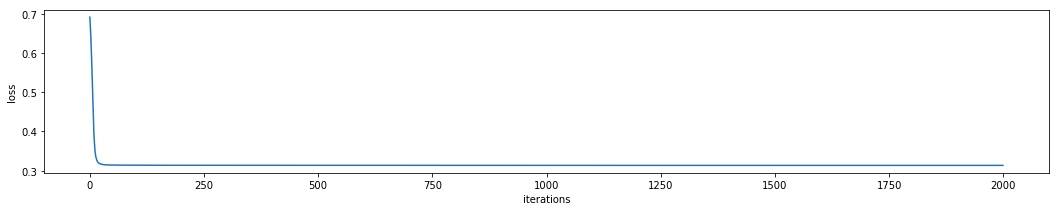

In [11]:
plt.figure(figsize=(18, 3))
plt.plot(loss_trace)
plt.ylabel('loss')
plt.xlabel('iterations');

## Predict underlying model given observed data

In [12]:
# predict 
# normalize using training data normalization 
sx_obs_zt, _ = normalize(xo_stats, data_norm)

p_vec = model_models.predict(sx_obs_zt)
print('True model: {}'.format(channel_type))
print('P(Kd | sx) = {:.2f}'.format(p_vec[0]))
print('P(Ks | sx) = {:.2f}'.format(p_vec[1]))

True model: kslow
P(Kd | sx) = 0.00
P(Ks | sx) = 1.00


## Predict test data and calculate test cross entropy loss

In [13]:
sx_test_zt, data_norm = normalize(sx_test, data_norm)
p = model_models.predict(sx_test_zt)[:, 1]
y = np.array(m_test)

In [14]:
cel = -(y * np.log(p) + (1 - y) * np.log(1 - p))
print('Cross entropy test loss: {:.6f}'.format(cel.mean()))

Cross entropy test loss: 0.000014


In [15]:
model_idx_posterior_dict = dict(sx_train=sx, sx_test=sx_test, mtrain=m, mtest=m_test, data_norm=data_norm, 
                           sx_obs=xo_stats, model_idx_mdn=model_models, prior_lims_kd=prior_lims_kd, 
                           prior_lims_ks=prior_lims_ks)

## Given the predicted underlying model we can learn the posterior of its parameters

In [16]:
result_dict.keys()

dict_keys(['params_kd', 'sx_kd', 'gt_kd', 'prior_lims_kd', 'params_ks', 'sx_ks', 'gt_ks', 'prior_lims_ls', 'seed', 'n_samples', 'cython'])

In [17]:
predicted_model_idx = np.argmax(p_vec)
predicted_channel_type = ['kd', 'ks'][predicted_model_idx]
gt = GT[channel_type]
n_params_pred = len(gt)

# get corresponding data 
sx_pred = result_dict['sx_' + predicted_channel_type]
params_pred = result_dict['params_' + predicted_channel_type]

# remove nans 
sx_new = []
params_new = []
for p, stats in zip(params_pred, sx_pred): 
    if np.isfinite(stats).all(): 
        sx_new.append(stats.tolist())
        params_new.append(p)
sx_pred_all = np.array(sx_new)
params_pred_all = np.array(params_new)

In [18]:
sx_pred_all.shape

(100000, 25)

In [19]:
ntest = 1000
ntrain = sx_pred_all.shape[0] - ntest
sx_pred = sx_pred_all[:ntrain, ]
sx_pred_test = sx_pred_all[ntrain:]

params_pred = params_pred_all[:ntrain, ]
params_pred_test = params_pred_all[ntrain:, ]

In [20]:
predicted_channel_type

'ks'

In [21]:
# define a network to approximate the posterior with a MoG 
n_components = 3
model_params_mdn = MultivariateMogMDN(ndim_input=n_stats, ndim_output=n_params_pred, n_hidden_layers=2, 
                                      n_hidden_units=10, n_components=n_components)
optimizer = torch.optim.Adam(model_params_mdn.parameters(), lr=0.01)
trainer = Trainer(model_params_mdn, optimizer, verbose=True)

In [22]:
# normalize training data: k data only 
sx_normed, data_norm = normalize(sx_pred)

# normalize the parameters as well 
params_ztrans, prior_norm = normalize(params_pred)

In [23]:
loss_trace = trainer.train(sx_normed, params_ztrans, n_epochs=100, n_minibatch=int(sx_pred.shape[0] / 100))

training: 100%|██████████| 100/100 [13:53<00:00,  8.43s/it]


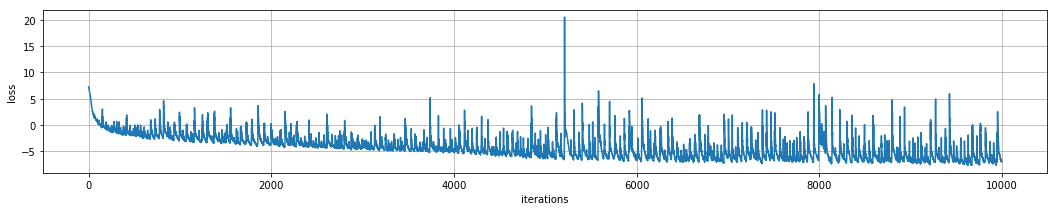

In [24]:
plt.figure(figsize=(18, 3))
plt.plot(loss_trace)
plt.ylabel('loss')
plt.xlabel('iterations');
plt.grid()

In [25]:
# normalize the observed data with training norm 
sx_obs, data_norm = normalize(xo_stats.squeeze(), data_norm)

In [26]:
# predict MoG parameters given observed data 
mog_posterior_pytorch = model_params_mdn.predict(sx_obs.reshape(1, -1))

## Plot the learned MoG posterior using delfi distribution class

In [27]:
# define as delfi distribution
mog_posterior_delfi_zt = mog_posterior_pytorch.get_dd_object()

In [28]:
# transform back to prior ranges 
mog_posterior_delfi = mog_posterior_delfi_zt.ztrans_inv(mean=prior_norm[0], std=prior_norm[1])

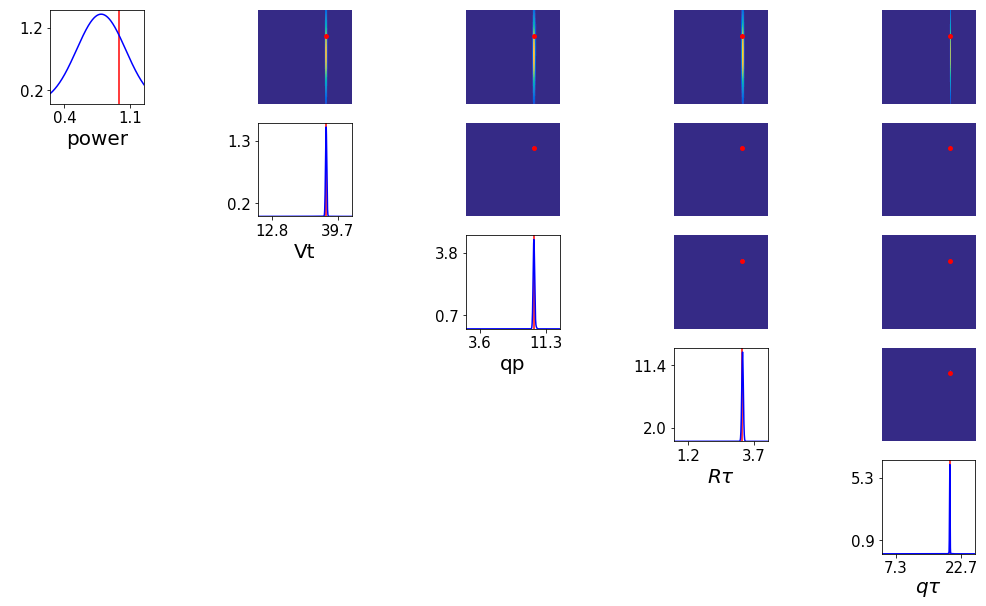

In [29]:
fig, ax = plot_pdf(mog_posterior_delfi, lims=prior_lims, figsize=(18, 10), ticks=True, 
                   labels_params=LP[channel_type], gt=gt)

In [30]:
fn = time_stamp + 'channel_posterior_{}_ntrain{}_nb{}.png'.format(channel_type, int(ntrain), n_components)
fig.savefig(os.path.join('../figures', fn), dpi=300)

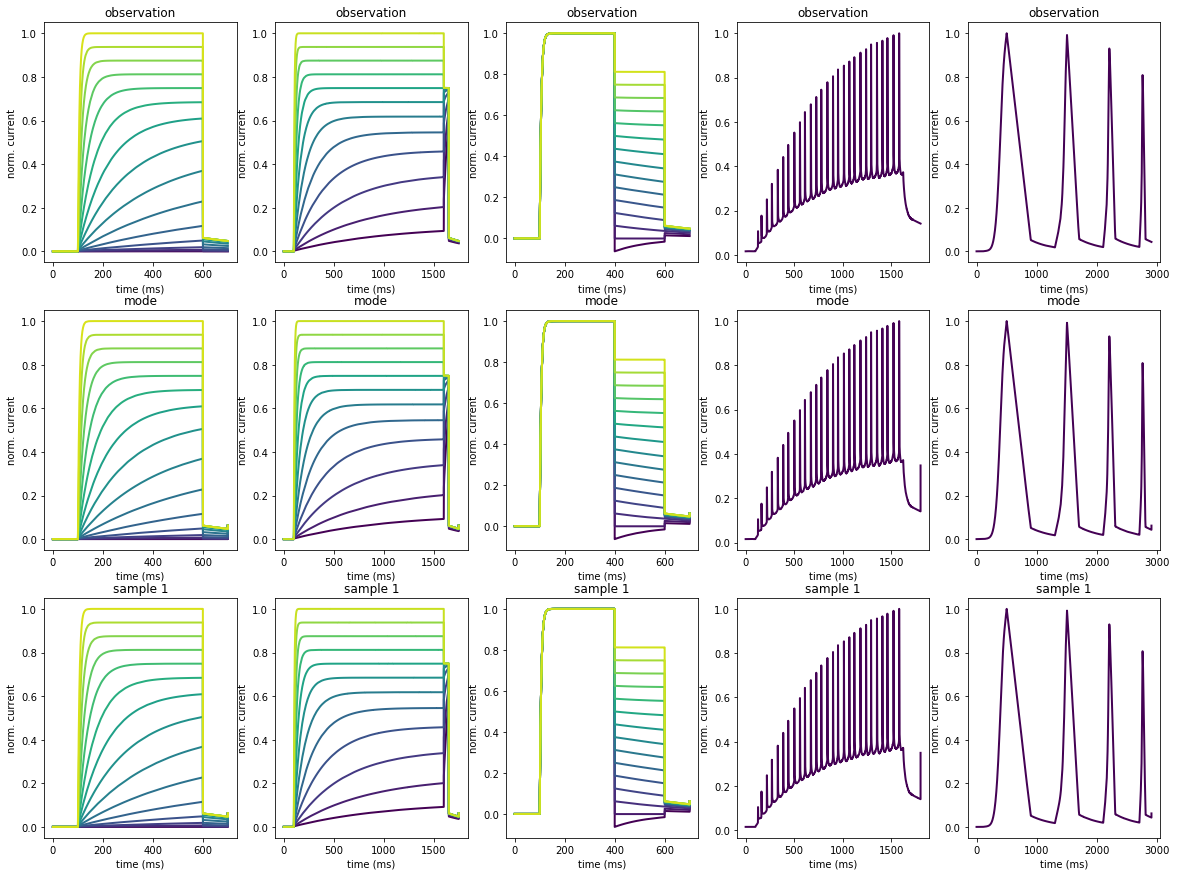

In [31]:
posterior = mog_posterior_delfi
n_params = len(gt)
lims = prior_lims

mean, S = posterior.calc_mean_and_cov()
# m = posterior.xs[0].m
# S = posterior.xs[0].S

prot = ['v_act','v_inact','v_deact','v_ap','v_ramp']
num_protocols = len(prot)

num_samp = 1

# sampling at contour of 1 covariance away from mean (if samples from outside the prior box, contour is at prior box)
x_samp = np.random.randn(n_params, num_samp)
x_samp = np.divide(x_samp, np.linalg.norm(x_samp, axis=0))
x_samp = (np.dot(S, x_samp)).T + mean

# # sample from posterior
# x_samp = posterior.gen(n_samples=num_samp)

# correct for samples outside the prior box
x_samp = np.maximum(x_samp, lims[:,0])
x_samp = np.minimum(x_samp, lims[:,1])

params = np.concatenate((np.array([mean]), x_samp))

fig = plt.figure(figsize = (20, 10 + num_samp * 5))

# set up a simulator 
m = ChannelSingle(channel_type=channel_type, n_params=n_params, cython=cython)
s = ChannelStats(channel_type=predicted_channel_type)

for i in range(1+num_samp):
    x = m.gen_single(params[i, :])
    for p in range(num_protocols):
        I = x[prot[p]]['data']
        t = x[prot[p]]['time']
        num_levels = len(I[:,0])
        cm1 = mpl.cm.viridis
        col1 = [cm1(1.*k/num_levels) for k in range(num_levels)]
        
        for j in range(num_levels):
            if i==0:
                plt.subplot(2+num_samp,num_protocols,p+1)
                plt.plot(t, xo[0][0][prot[p]]['data'][j,], color = col1[j], lw=2)
                plt.xlabel('time (ms)')
                plt.ylabel('norm. current')
                plt.title('observation')
                
                plt.subplot(2+num_samp,num_protocols,num_protocols+p+1)
                plt.plot(t, I[j,], color = col1[j], lw=2)
                plt.xlabel('time (ms)')
                plt.ylabel('norm. current')
                plt.title('mode')
            else:
                plt.subplot(2+num_samp,num_protocols,(i+1)*num_protocols+p+1)
                plt.plot(t, I[j,], color = col1[j], lw=2)
                plt.xlabel('time (ms)')
                plt.ylabel('norm. current')
                plt.title('sample '+str(num_samp-i+1))

how to quantify the performance: 

sensitvity analysis? 

predictive checking? 

painfree estimate Macke, Wichmann 
coverage analysis 
Prangle paper, coverage property 

compare again SCM ABC, DIYABC, just sample a lot of data

it works on toy, why to do it? some real world examples



## Save results to file

In [32]:
parameter_posterior_dict = dict(xo=xo, sxo=xo_stats, parameter_mdn=model_params_mdn, gt=GT, labels=LP, 
                           sx_train=sx_pred, sx_test=sx_pred_test, data_norm=data_norm, prior_norm=prior_norm,
                           params_pred=params_pred, params_pred_test=params_pred_test, 
                           predicted_channel_type=predicted_channel_type, loss_trace=loss_trace)

In [33]:
result_dict = dict(model_idx_posterior=model_idx_posterior_dict, 
                   parameter_posterior=parameter_posterior_dict)

In [36]:
filename = time_stamp + '_learned_posteriors_pospischil_ntrain{}_{}_nc{}.p'.format(sx.shape[0], channel_type, n_components)
folder = '../data/'
with open(os.path.join(folder, filename), 'wb') as outfile: 
    pickle.dump(result_dict, outfile, protocol=pickle.HIGHEST_PROTOCOL)